# Data Limitations

- Options Prices data from wrds , takes the best bid and best offer among all exchanges and passes the final value, this will cause illiquid options to have a large differential with the blackscholes theoretical price 
- we extracted 1 year of data, hence the mean rate of return was used within the given period, i.e. we should have download a 2 year data, and use the earlier 1 year data as the mean of return
- return rate = 0.10% , put as 0.0010 ? or keep 0.10 ? 
- need to do standardization ? 

https://www.codearmo.com/blog/pricing-options-monte-carlo-simulation-python
https://towardsdatascience.com/monte-carlo-pricing-in-python-eafc29e3b6c9
https://www.pranav.ai/monte-carlo-options-python
https://medium.com/@polanitzer/geometric-brownian-motion-in-python-predict-the-bitcoin-prices-6d7e34d9b407

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib

from math import e

import scipy.stats
from scipy.stats import norm

from scipy import stats

import tensorflow as tf

In [2]:
from sklearn.linear_model import LinearRegression

from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn.tree import DecisionTreeRegressor

from sklearn.neighbors import KNeighborsRegressor

from sklearn.svm import SVR

# Bagging
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor

# Boosting
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.neural_network import MLPRegressor


from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error

from sklearn.feature_selection import chi2, f_regression
from sklearn.feature_selection import SelectKBest

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from tensorflow.keras.optimizers import SGD

from keras.wrappers.scikit_learn import KerasRegressor



In [3]:
### The code in this section is based on the work done by DovaX. 
### https://github.com/DovaX/artificial-neural-networks-in-option-pricing

class MyPlot:
    """Class for automated plotting of data"""

    def __init__(self):
        self.x_list = []
        self.y_list = []
        self.c_list = []
        self.label_list = []
        self.linewidth = []
        pass

    def load_data(self, filepath, sort=False):
        x, y = prepare_xy_data_from_file(filepath)
        if sort == True:
            x, y = sort_depth_value(x, y)
        return(x, y)

    def append_data(self, x, y, c, label, linewidth=2.0):
        self.x_list.append(x)
        self.y_list.append(y)
        self.c_list.append(c)
        self.label_list.append(label)
        self.linewidth.append(linewidth)

    def construct_plot(self, title, xlabel, ylabel, save=False, xymin=False, xymax=False, figsize=(7, 5), scatter=False, vlines=[], xticks_bool=False):
        fig = plt.figure(figsize=figsize)
        ax1 = fig.add_subplot(111)
        ax1.set_title(title)
        ax1.set_xlabel(xlabel)
        ax1.set_ylabel(ylabel)
        for i in range(len(self.x_list)):
            if scatter == True:
                ax1.scatter(self.x_list[i], self.y_list[i], c=self.c_list[i],
                            label=self.label_list[i], s=self.linewidth[i])
            else:
                ax1.plot(self.x_list[i], self.y_list[i], c=self.c_list[i],
                         label=self.label_list[i], linewidth=self.linewidth[i])
#         if xticks_bool == True:
#             plt.xticks(np.arange(252, 4698, 252*2), ["2021-01", "2021-02", "2021-03", "2021-04", "2021-05", 
#                                                      "2021-06", "2021-07", "2021-08", "2021-09",
#                                                     "2021-10", "2021-11", "2021-12"], rotation=60)

        for line in vlines:
            plt.axvline(x=line, color="k")

        leg = ax1.legend()
        if xymin != False:
            ax1.set_xlim(xmin=xymin[0])
            ax1.set_ylim(ymin=xymin[1])
        if xymax != False:
            ax1.set_xlim(xmax=xymax[0])
            ax1.set_ylim(ymax=xymax[1])
            
        if save != False:
            fig.savefig("../images\\"+save, format="png",
                        dpi=200, bbox_inches='tight')
        return(ax1, fig)

    def plot_interest(self, title, xlabel, ylabel, save=False, xymin=False, xymax=False, figsize=(7, 5), scatter=False, vlines=[], xticks_bool=False):
        fig = plt.figure(figsize=figsize)
        ax1 = fig.add_subplot(111)
        ax1.set_title(title)
        ax1.set_xlabel(xlabel)
        ax1.set_ylabel(ylabel)
        for i in range(len(self.x_list)):
            if scatter == True:
                ax1.scatter(self.x_list[i], self.y_list[i], c=self.c_list[i],
                            label=self.label_list[i], s=self.linewidth[i])
            else:
                ax1.plot(self.x_list[i], self.y_list[i], c=self.c_list[i],
                         label=self.label_list[i], linewidth=self.linewidth[i])
#         if xticks_bool == True:
#             plt.xticks(np.arange(263, 4957, 252*2), ["2021-01", "2021-02", "2021-03", "2021-04", "2021-05", 
#                                                      "2021-06", "2021-07", "2021-08", "2021-09",
#                                                     "2021-10", "2021-11", "2021-12"], rotation=60)

        for line in vlines:
            plt.axvline(x=line, color="k")

        leg = ax1.legend()
        if xymin != False:
            ax1.set_xlim(xmin=xymin[0])
            ax1.set_ylim(ymin=xymin[1])
        if xymax != False:
            ax1.set_xlim(xmax=xymax[0])
            ax1.set_ylim(ymax=xymax[1])
            
        if save != False:
            fig.savefig("../images\\"+save, format="png",
                        dpi=200, bbox_inches='tight')
        return(ax1, fig)

# Load main datasets obtained from OptionMetrics

In [4]:
dfo = pd.read_csv('Option_Prices.csv')
dff = pd.read_csv('Forward_Price.csv')

<ipython-input-4-d96346a74b95>:1: DtypeWarning: Columns (32,35) have mixed types. Specify dtype option on import or set low_memory=False.
  dfo = pd.read_csv('Option_Prices.csv')


In [5]:
dfo.rename(
    columns = {
               'strike_price_of_option_x1000':'strike_price', 
               'best_bid_highest_closing_bid_acrossAllExchanges':'best_bid',
               'best_offer_lowest_closing_ask_acrossAllExchanges':'best_offer'
              }, inplace = True)

# Mapping forward prices from dff to dfo 

In [6]:
#making common unique identifier
cols = ['date','expiration','ticker']
dff['x'] = dff[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

#build dict
dff_dict = dict(zip(dff['x'],dff['ForwardPrice']))

# mapping and making of same common unique identifer
cols = ['date','exdate','ticker']
dfo['x'] = dfo[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
dfo['forward_price'] = dfo['x'].map(dff_dict)

In [7]:
# filter for required columns
cols = ['date', 'symbol', 'exdate','days_to_expiry','cp_flag', 'exercise_style','strike_price','forward_price', 'impl_volatility', 'delta', 'gamma', 'vega', 'theta',
'optionid','ticker', 'issuer',  'best_bid', 'best_offer', 'volume','open_interest']

df0 = dfo.filter(cols)


#filter for VIX and Calls only
df0 = df0[(df0['ticker'] =='VIX') & (df0['cp_flag'] == 'C')]

# Set risk free rate

In [8]:
# Loading 3-month US treasury bill rate (risk free rate)
# https://fred.stlouisfed.org/

DTB3 = pd.read_csv("DTB3.csv")
MTB3 = pd.read_csv("TB3MS.csv")

In [9]:
DTB3['DTB3'] = DTB3['DTB3']/100
DTB3 = DTB3.dropna()

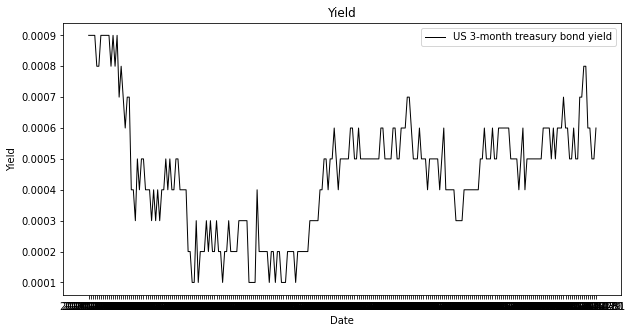

In [10]:
def plot_interest(treasury):
    """Plot 3-month US treasury bill"""
    plot2 = MyPlot()
    
    plot2.append_data(
        treasury['DATE'], treasury['DTB3'], 'k', 'US 3-month treasury bond yield', linewidth=1.0)
    
    plot2.plot_interest("Yield", "Date", "Yield",  figsize=(10, 5))


# plot risk free rate  
plot_interest(DTB3)

In [11]:
# ir = 0.001
# based on the Andrew Lo's paper, approximate the risk-free rate r for each option as the yield of 
# the 3-month Treasury bill on the close of the month before the initial activity in that option 

import datetime

# MTB3['DATE']=pd.to_datetime(MTB3['DATE'])
# MTB3['month']=MTB3['DATE'].dt.month

# MTB3 = MTB3.iloc[:-2,:]
MTB3['MTB3'] = MTB3['TB3MS']/100
MTB3

,DATE,TB3MS,MTB3
0,2020-12-01,0.09,0.0009
1,2021-01-01,0.08,0.0008
2,2021-02-01,0.04,0.0004
3,2021-03-01,0.03,0.0003
4,2021-04-01,0.02,0.0002
5,2021-05-01,0.02,0.0002
6,2021-06-01,0.04,0.0004
7,2021-07-01,0.05,0.0005
8,2021-08-01,0.05,0.0005
9,2021-09-01,0.04,0.0004


In [12]:
df0['date'] = pd.to_datetime(df0['date'],format='%Y%m%d')
df0['month']= df0['date'].dt.month
df0['ir'] = None

In [13]:
df0['ir'] = np.where(df0['month']==1, 0.0009, df0['ir'])
df0['ir'] = np.where(df0['month']==2, 0.0008, df0['ir'])
df0['ir'] = np.where(df0['month']==3, 0.0004, df0['ir'])
df0['ir'] = np.where(df0['month']==4, 0.0003, df0['ir'])
df0['ir'] = np.where(df0['month']==5, 0.0002, df0['ir'])
df0['ir'] = np.where(df0['month']==6, 0.0002, df0['ir'])
df0['ir'] = np.where(df0['month']==7, 0.0004, df0['ir'])
df0['ir'] = np.where(df0['month']==8, 0.0005, df0['ir'])
df0['ir'] = np.where(df0['month']==9, 0.0005, df0['ir'])
df0['ir'] = np.where(df0['month']==10, 0.0004, df0['ir'])
df0['ir'] = np.where(df0['month']==11, 0.0005, df0['ir'])
df0['ir'] = np.where(df0['month']==12, 0.0005, df0['ir'])

df0['ir'] =df0['ir'].astype(float)

In [14]:
# filter for required columns
cols = ['date', 'symbol', 'exdate','days_to_expiry','cp_flag', 'exercise_style','strike_price','forward_price', 'impl_volatility', 'delta', 'gamma', 'vega', 'theta',
'optionid','ticker', 'issuer',  'best_bid', 'best_offer', 'volume','open_interest','ir']

df = df0.filter(cols)

# Data Wrangling

In [15]:
#getting mid price to remove broker fees
df['mid_price'] = df[['best_bid','best_offer']].mean(axis=1)

#removing strike price of x1000 , data provided was given x1000 for strike
df['strike_price'] = df['strike_price']/1000

#finding days to expiry
# df['date'] = pd.to_datetime(df['date'],format='%Y%m%d')
df['exdate'] =  pd.to_datetime(df['exdate'],format='%Y%m%d')
df['days_to_expiry'] = ((df['exdate'] - df['date']) / np.timedelta64(1, 'D'))

# input features
df['T-t'] = df['days_to_expiry']/252  # in units of a year 
# reversing to current stock price
df['stock_price'] = df['forward_price'] / (e ** (df['ir']*df['T-t']))
#input features 2
df['S/X'] = df['stock_price'] / df['strike_price']


## have to drop these few rows  as their forward price seems to have converged to the option price, as the expiry date is 0 
rows_to_drop = df.loc[df['forward_price'] < 5].index
df = df.drop(rows_to_drop,axis=0)

#####################################

# finding daily returns and mean returns , vol

#getting the each daily unique forward price
daily_unique_price = df[['date','forward_price']].groupby('date', as_index=False).first()


# daily pct return
daily_unique_price['daily_returns'] = daily_unique_price['forward_price'].pct_change()

# annual return
annual_return = daily_unique_price.iloc[daily_unique_price['date'].argmax()]['forward_price'] / daily_unique_price.iloc[daily_unique_price['date'].argmin()]['forward_price'] - 1

#vol
daily_volatility = daily_unique_price['daily_returns'].std()
annual_volatility = daily_volatility * math.sqrt(252)

#####################################


### Rename columns ## 
rename_cols = {'mid_price' : 'Mkt_Opt_Price',
               'delta' : 'Mkt_Delta' }
df = df.rename(columns=rename_cols)
### Rename columns ## 


###### Black-Scholes ###### 
def BlackScholesCall(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

df['BS_Opt_Price'] = df.apply(lambda df: BlackScholesCall(df['stock_price'],df['strike_price'],df['ir'],annual_volatility,df['T-t']),axis = 1).round(5)
###### Black-Scholes ###### 


###### Adjust for ITM/OTM/ATM ###### 
conditions = [round(df['stock_price']*2)/2 == df['strike_price'],
round(df['stock_price']*2)/2 > df['strike_price'],
round(df['stock_price']*2)/2 < df['strike_price']
]

choices = ['ATM',
'ITM',
'OTM'
]

df['I_O_TM'] = np.select(conditions,choices)
###### Adjust for ITM/OTM/ATM ###### 



### Differential Between Market and Black-Scholes ### 

df['Diff_BS_Mkt_Opt_Price'] =( df['Mkt_Opt_Price'] - df['BS_Opt_Price']  ) /  df['BS_Opt_Price'] * 100


### Differential Between Market and Black-Scholes ### 


df['C/X'] = df['Mkt_Opt_Price'] /df['strike_price']

# Filter
- < 50 strikes
- Market Option Prices > 0.10 
- days_to_expiry > 10

In [16]:
df = df.loc[df['strike_price']< 50]
df = df.loc[df['Mkt_Opt_Price'] > 0.1]
df = df.loc[df['days_to_expiry'] > 10]

cols = ['optionid','BS_Opt_Price', 'S/X',  'T-t', 'days_to_expiry', 'strike_price', 'Mkt_Opt_Price','I_O_TM', 'Diff_BS_Mkt_Opt_Price',
'stock_price', 'forward_price', 'impl_volatility', 'Mkt_Delta', 'gamma', 'vega', 'theta','date', 'exdate','ir','C/X'
]

df2 = df.filter(cols)

Text(0.5, 1.0, 'C/X 2021 Distribution')

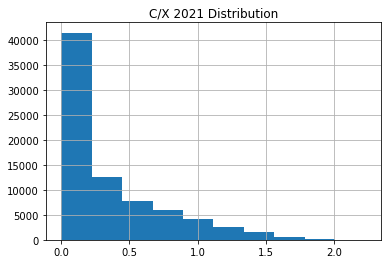

In [17]:
(df2['Mkt_Opt_Price']/df2['strike_price']).hist()
plt.title('C/X 2021 Distribution')

# EDA - Plot Graph Functions 

In [18]:
### TO KEEP #### 
pd.Series(df['strike_price']).value_counts() 

def plot_particular_option(df, strike): 

    """plots particular call option (X=30, maturity less than 100 days for example)""" 

     

    strike_bool = df['strike_price'] == strike 

  

    shortmaturity1 = df['T-t'] < 5/12

    shortmaturity2 = df['T-t'] < 4/12 

    shortmaturity3 = df['T-t'] < 3/12 

    shortmaturity4 = df['T-t'] < 2/12 

    shortmaturity5 = df['T-t'] < 1/12 

  

    ss1 = df[strike_bool & shortmaturity1] 

    ss2 = df[strike_bool & shortmaturity2] 

    ss3 = df[strike_bool & shortmaturity3] 

    ss4 = df[strike_bool & shortmaturity4] 

    ss5 = df[strike_bool & shortmaturity5] 

  

    name = "Call option price distribution (X="+str(strike)+")" 

  

  

    plot1 = MyPlot() 

    # plot1.append_data(ss1['stock_price']/ss1['strike_price'], ss1['Mkt_Opt_Price']/ss1['strike_price'], 'y', '120<T<150', linewidth=1.5) 

    # plot1.append_data(ss2['stock_price']/ss2['strike_price'], ss2['Mkt_Opt_Price']/ss2['strike_price'], 'k', '90<T<120', linewidth=1.5) 

    # plot1.append_data(ss3['stock_price']/ss3['strike_price'], ss3['Mkt_Opt_Price']/ss3['strike_price'], 'r', '60<T<90', linewidth=1.5) 

    # plot1.append_data(ss4['stock_price']/ss4['strike_price'], ss4['Mkt_Opt_Price']/ss4['strike_price'], 'b', '30<T<60', linewidth=1.5) 

    # plot1.append_data(ss5['stock_price']/ss5['strike_price'], ss5['Mkt_Opt_Price']/ss5['strike_price'], 'g', 'T<30', linewidth=1.5) 

    plot1.append_data(ss1['stock_price']/ss1['strike_price'], ss1['Mkt_Opt_Price'], 'y', '120<T<150', linewidth=1.5) 

    plot1.append_data(ss2['stock_price']/ss2['strike_price'], ss2['Mkt_Opt_Price'], 'k', '90<T<120', linewidth=1.5) 

    plot1.append_data(ss3['stock_price']/ss3['strike_price'], ss3['Mkt_Opt_Price'], 'r', '60<T<90', linewidth=1.5) 

    plot1.append_data(ss4['stock_price']/ss4['strike_price'], ss4['Mkt_Opt_Price'], 'b', '30<T<60', linewidth=1.5) 

    plot1.append_data(ss5['stock_price']/ss5['strike_price'], ss5['Mkt_Opt_Price'], 'g', 'T<30', linewidth=1.5)      

    plot1.construct_plot(name, "$S/X$", "$C/X$",  xymin=[0, 0], scatter=True) 

  

#     plot1.construct_plot(name, "$S$", "$C$", save= str(strike)+".png",  

#                          xymin=[1050, 0], xymax=[1550, 200], scatter=True) 

  


 


############################ Multi-color chart ######################


def plot_particular_moneyness(df): 

    """plot call options with fixed moneyness (maturity less than 100 days for example)""" 

     

    moneyness1 = (df['I_O_TM'] == 'OTM') & (df['S/X'] <= 0.99125)

    moneyness2 = (df['I_O_TM'] == 'ATM') & (df['S/X'] <= 1.013)

    moneyness3 = (df['I_O_TM'] == 'ITM') & (df['S/X'] > 1.009)
    

    shortmaturity1 = (df['T-t'] >= 1/2 )    
  
    shortmaturity2 = df['T-t'] < 1/2 

    shortmaturity3 = df['T-t'] < 1/12 

  

  

    ss1 = df[moneyness1 & shortmaturity1] ## OTM and more than 6 months

    ss2 = df[moneyness1 & shortmaturity2] ## OTM and less than 6 months

    ss3 = df[moneyness1 & shortmaturity3] ## OTM and less than 1 month

  

    ss4 = df[moneyness2 & shortmaturity1] # ATM and more than 6 months

    ss5 = df[moneyness2 & shortmaturity2] # ATM and less than 6 months

    ss6 = df[moneyness2  & shortmaturity3] # ATM and less than 1 month

  

    ss7 = df[moneyness3 & shortmaturity1] # ITM and more than 6 months

    ss8 = df[moneyness3 & shortmaturity2] # ITM and less than 6 months

    ss9 = df[moneyness3 & shortmaturity3] # ITM and less than 1 month

  

    name = "Call option moneyness distribution" 

     

  

    plot1 = MyPlot() 

    plot1.append_data(ss1['S/X'], ss1['C/X'], 

                      '#550099', '$T-t\geq1/2$', linewidth=1.0) 

    plot1.append_data(ss2['S/X'], ss2['C/X'], 

                      '#000099', '$1/2>T-t\geq1/12$', linewidth=1.0) 

    plot1.append_data(ss3['S/X'], ss3['C/X'], 

                      '#009999', '$T-t<1/12$', linewidth=1.0) 

  

    plot1.append_data(ss4['S/X'], ss4['C/X'], 

                      '#7700cc', '', linewidth=1.0) 

    plot1.append_data(ss5['S/X'], ss5['C/X'], 

                      '#0000cc', '', linewidth=1.0) 

    plot1.append_data(ss6['S/X'], ss6['C/X'], 

                      '#00cccc', '', linewidth=1.0) 

  

    plot1.append_data(ss7['S/X'], ss7['C/X'], 

                      '#9900ee', '', linewidth=1.0) 

    plot1.append_data(ss8['S/X'], ss8['C/X'], 

                      '#0000ee', '', linewidth=1.0) 

    plot1.append_data(ss9['S/X'], ss9['C/X'], 

                      '#00eeee', '', linewidth=1.0) 
  

    vlines = [0.95, 1.05] 

    plot1.construct_plot(name, "Moneyness $S/X$", "$C/X$",

                         xymin=[0.0, 0.0], xymax=[1.5, 0.7], scatter=True, vlines=vlines) 

  

 

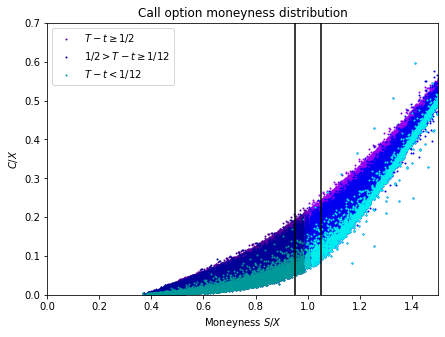

In [19]:
plot_particular_moneyness(df2)

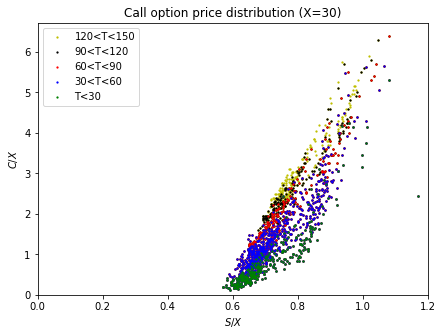

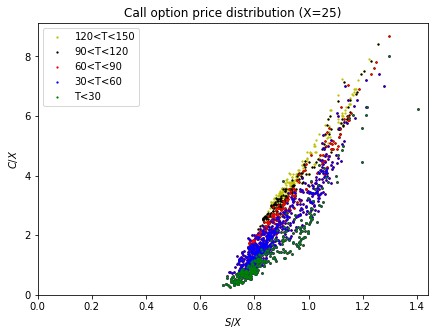

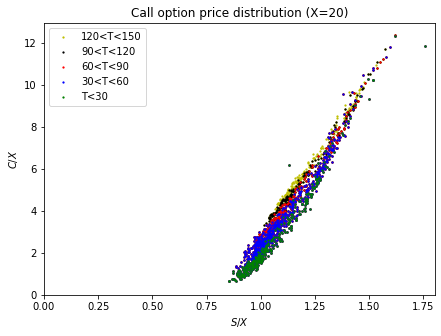

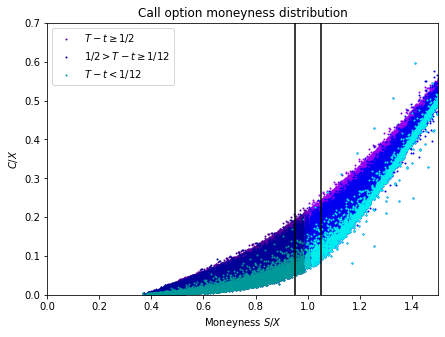

In [20]:
# plot call options 

plot_particular_option(df2, 30) 

plot_particular_option(df2, 25) 

plot_particular_option(df2, 20) 

# plot_particular_option(df2, 28) 

# plot_particular_option(df2, 29) 

# plot_particular_option(df2, 30) 

# plot moneyness 

plot_particular_moneyness(df2) 


# Train Test Split - Relative to dates
- Function for train test split
- Running train test split 

In [21]:
def splitTrainAndTest(X, Y, test_size):   # date in accending order
    
    
    X_train_calc = X.head(int((1-test_size) * len(X)))
    X_train = X_train_calc.iloc[:,0:2]
    Y_train = Y.head(int((1-test_size) * len(Y)))
    

    
    X_test_calc = X.tail(int((test_size) * len(X)))
    X_test = X_test_calc.iloc[:,0:2]
    Y_test = Y.tail(int((test_size) * len(Y)))
    
    
    
    return X_train_calc, X_test_calc, X_train, X_test, Y_train, Y_test

In [40]:
# X = df2[['T-t','S/X']]
X = df2[['T-t','S/X','BS_Opt_Price','strike_price','I_O_TM','Mkt_Opt_Price']] ## sort to date order and split manually 
Y = df2['Mkt_Opt_Price']/df2['strike_price']

X_train_calc, X_test_calc, X_train, X_test, Y_train, Y_test = splitTrainAndTest(X,Y,0.2)


# Deploy ANN Model 
- Function for 1) ANN Model Building  2) Performance Metrics PLotting
- Running model 

In [23]:
# function for ANN Model

def build(X):    
    nodes = 4
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.Dense(nodes,input_dim=X_train.shape[1], activation="sigmoid"))
    
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
              
    model.compile(loss='mse',optimizer='rmsprop')
#     model.compile(optimizer="adam",loss="binary_crossentropy",metrics=['accuracy'])
    
    model.summary()
    return model


def plotTrainingMetrics(train_loss, test_loss):
    matplotlib.rcParams['agg.path.chunksize'] = 100000
    plt.figure(figsize=(8,6))
    plt.plot(train_loss, 'r-', label='Train')
    plt.plot(test_loss, 'k-', label = 'Test')
    plt.legend(loc='upper right')
    plt.xlabel('Epoch',fontsize=20,fontname='Times New Roman')
    plt.ylabel('Loss',fontsize=20,fontname='Times New Roman')


# def r_squared(y, y_hat):
#     y_bar = y.mean()
#     ss_tot = ((y-y_bar)**2).sum()
#     ss_res = ((y-y_hat)**2).sum()
#     return 1 - (ss_res/ss_tot)


In [24]:
# df2['Mkt_Opt_Price'] = Y

In [25]:
# Y.shape

In [26]:
# pd.DataFrame(Y).hist()

In [27]:
model = build(X.iloc[:,0:2])
Y=model.predict(X.iloc[:,0:2])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 12        
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________
2401/2401 [==============================] - 4s 2ms/step


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 4)                 12        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1025/1025 [==============================] - 3s 2ms/step - loss: 0.1672
Epoch 2/20
1025/1025 [==============================] - 2s 2ms/step - loss: 0.0779
Epoch 3/20
1025/1025 [==============================] - 2s 2ms/step - loss: 0.0267
Epoch 4/20
1025/1025 [==============================] - 3s 3ms/step - loss: 0.0156
Epoch 5/20
1025/1025 [==============================] - 2s 2ms/step - loss: 0.0139
Epoch 6/20
1025/1025 [=================

1025/1025 [==============================] - 2s 1ms/step - loss: 0.0112
Epoch 3/20
1025/1025 [==============================] - 2s 2ms/step - loss: 0.0112
Epoch 4/20
1025/1025 [==============================] - 2s 2ms/step - loss: 0.0112
Epoch 5/20
1025/1025 [==============================] - 2s 1ms/step - loss: 0.0112
Epoch 6/20
1025/1025 [==============================] - 2s 2ms/step - loss: 0.0112
Epoch 7/20
1025/1025 [==============================] - 2s 2ms/step - loss: 0.0112
Epoch 8/20
1025/1025 [==============================] - 2s 2ms/step - loss: 0.0112
Epoch 9/20
1025/1025 [==============================] - 2s 2ms/step - loss: 0.0112
Epoch 10/20
1025/1025 [==============================] - 1s 1ms/step - loss: 0.0112
Epoch 11/20
1025/1025 [==============================] - 1s 1ms/step - loss: 0.0112
Epoch 12/20
1025/1025 [==============================] - 3s 3ms/step - loss: 0.0112
Epoch 13/20
1025/1025 [==============================] - 2s 2ms/step - loss: 0.0112
Epoch 14/20

1025/1025 [==============================] - 2s 1ms/step - loss: 0.0112
Epoch 14/20
1025/1025 [==============================] - 2s 2ms/step - loss: 0.0112
Epoch 15/20
1025/1025 [==============================] - 2s 2ms/step - loss: 0.0112
Epoch 16/20
1025/1025 [==============================] - 2s 1ms/step - loss: 0.0112
Epoch 17/20
1025/1025 [==============================] - 1s 1ms/step - loss: 0.0112
Epoch 18/20
1025/1025 [==============================] - 1s 1ms/step - loss: 0.0112
Epoch 19/20
1025/1025 [==============================] - 2s 1ms/step - loss: 0.0112
Epoch 20/20
481/481 [==============================] - 1s 1ms/step - loss: 0.0114
Epoch 1/20
1025/1025 [==============================] - 2s 2ms/step - loss: 0.0112
Epoch 2/20
1025/1025 [==============================] - 2s 2ms/step - loss: 0.0112
Epoch 3/20
1025/1025 [==============================] - 2s 1ms/step - loss: 0.0112
Epoch 4/20
1025/1025 [==============================] - 2s 2ms/step - loss: 0.0112
Epoch 5/20

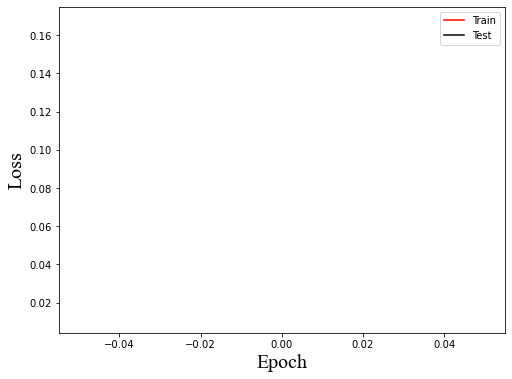

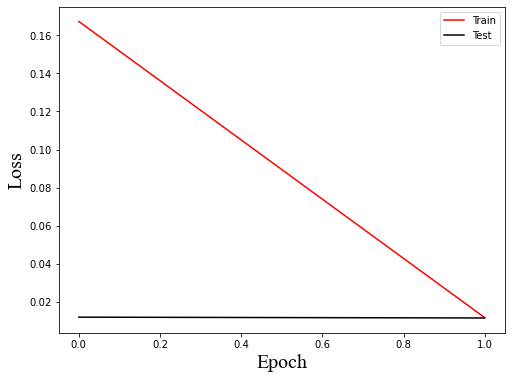

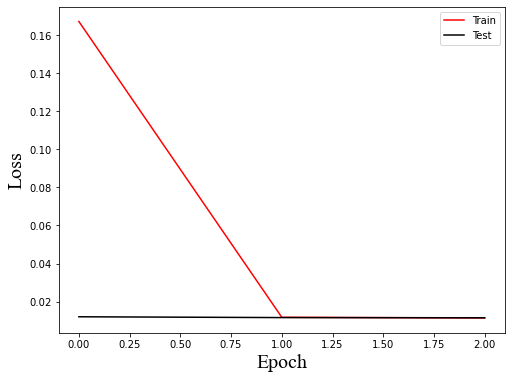

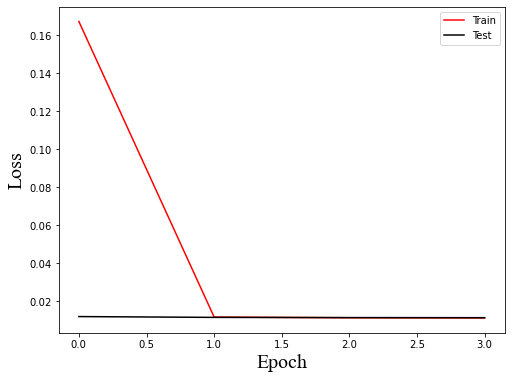

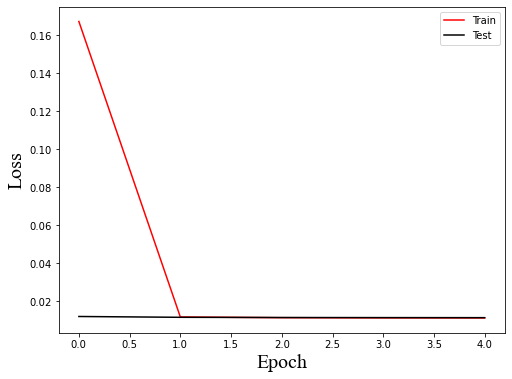

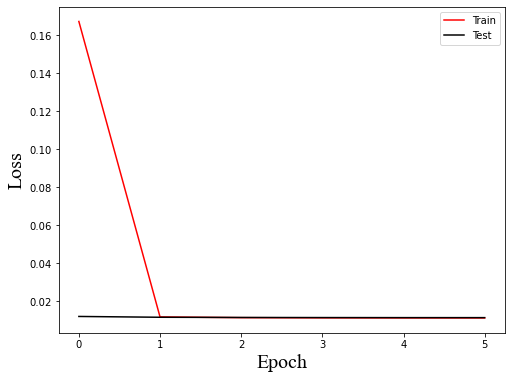

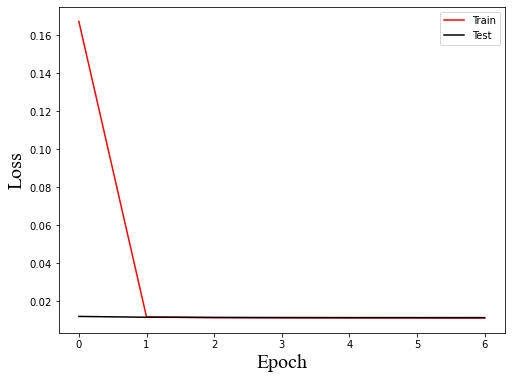

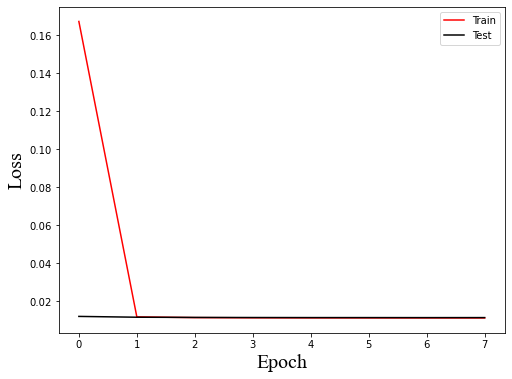

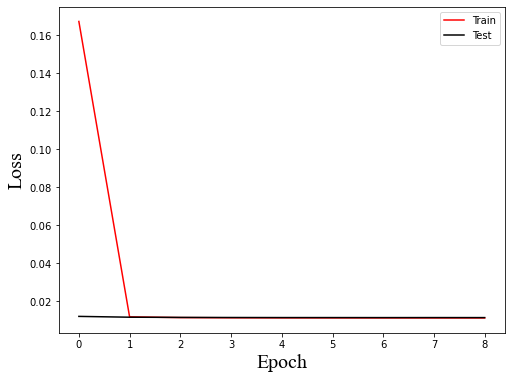

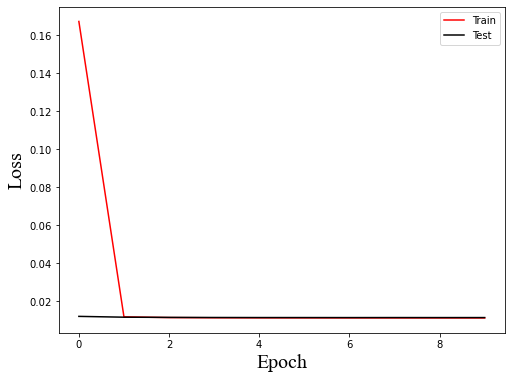

In [28]:
model = build(X_train)
# num_of_sample = int(0.8 * len(data))
# num_of_epochs = 10
num_of_iter = 10
test_loss_min = 1

train_loss = list()
test_loss = list()



from keras import callbacks

 
for i in range(num_of_iter):   

    # Learning and Evaluation
    
    # earlystopping = callbacks.EarlyStopping(monitor ="val_loss", mode ="min", patience = 5, 
    #                                         restore_best_weights = True)
  
    # history = model.fit(X_train, Y_train, batch_size = 80, 
    #                 epochs = 10, validation_data =(X_test, Y_test), 
    #                 callbacks =[earlystopping])
    
    history = model.fit(X_train,
                        Y_train,
                        batch_size=60,
                        epochs=20,
                        verbose=1)
    
    # Save training metrics
    train_loss.append(history.history['loss'][0])
    
    # Save testing metrics
    eval_metrics = model.evaluate(X_test, Y_test)
    test_loss.append(eval_metrics)
    
    # Plot loss through training and testing
    plotTrainingMetrics(train_loss, test_loss)

    if test_loss_min > eval_metrics:
          print("INFO: Saving best candidate model with error = {0:.9f} . Previous best was: error = {1:.9f}".format(eval_metrics, test_loss_min))
          test_loss_min = eval_metrics
          best_model = model
          
          # Save the model
model.save_weights('ANN' + '_weights.h5')


## Performance @ All Samples 
## - ITM 
## - OTM 
## - ATM

In [29]:
#--------------  All samples --------------------

pricing_data = pd.DataFrame(columns=[ 'test','mse_BS', 'rmse_BS', 'mae_BS', 'mpe_BS','mse_NN', 'rmse_NN', 'mae_NN', 'mpe_NN'])

Y_hat = model.predict([X_test]) 
Y_BS  = X_test_calc['BS_Opt_Price']/X_test_calc['strike_price']

diff_NN = Y_test - Y_hat[:,0]
diff_BS = Y_test - Y_BS

mse_NN = np.mean(diff_NN**2) 
mse_BS = np.mean(diff_BS**2) 

pricing_data = pricing_data.append([{ 
                                    'test': 'All', 
                                    'mse_BS': mse_BS ,
                                    'rmse_BS': np.sqrt(mse_BS) ,
                                    'mae_BS': np.mean(abs(diff_BS)) ,
                                    'mpe_BS': np.sqrt(mse_BS)/np.mean(Y_BS),
                                    'mse_NN': mse_NN ,
                                    'rmse_NN': np.sqrt(mse_NN) ,
                                    'mae_NN': np.mean(abs(diff_NN)) ,
                                    'mpe_NN': np.sqrt(mse_NN)/np.mean(Y_hat)
                                    
                                    }], 
                                    ignore_index=True)

pricing_data

481/481 [==============================] - 1s 1ms/step


<ipython-input-29-973b6e18070a>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pricing_data = pricing_data.append([{


,test,mse_BS,rmse_BS,mae_BS,mpe_BS,mse_NN,rmse_NN,mae_NN,mpe_NN
0,All,0.01034,0.101684,0.07499,0.232428,0.011372,0.106638,0.040254,0.315407


In [30]:
X_test

,T-t,S/X
337210,0.087302,0.504638
337211,0.087302,0.473099
337212,0.087302,0.445269
337213,0.087302,0.420532
337214,0.087302,0.398399
...,...,...
390117,0.130952,0.539298
390118,0.130952,0.505592
390119,0.130952,0.475851
390120,0.130952,0.449415


In [31]:
#--------------  In the money samples --------------------

X_ITM = X[X['I_O_TM'] == 'ITM'] 
Y_ITM = X_ITM['Mkt_Opt_Price']/X_ITM['strike_price']

X_train_calc, X_test_calc, X_train, X_test, Y_train, Y_test = splitTrainAndTest(X_ITM,Y_ITM,0.2)

#####################################
pricing_data_ITM = pd.DataFrame(columns=['test', 'mse_BS', 'rmse_BS', 'mae_BS', 'mpe_BS','mse_NN', 'rmse_NN', 'mae_NN', 'mpe_NN'])

Y_hat = model.predict([X_test]) 
Y_BS  = X_test_calc['BS_Opt_Price']/X_test_calc['strike_price']

diff_NN = Y_test - Y_hat[:,0]
diff_BS = Y_test - Y_BS

mse_NN = np.mean(diff_NN**2) 
mse_BS = np.mean(diff_BS**2) 

pricing_data_ITM = pricing_data.append([{ 
                                     'test': 'ITM', 
                                     'mse_BS': mse_BS ,
                                     'rmse_BS': np.sqrt(mse_BS) ,
                                     'mae_BS': np.mean(abs(diff_BS)) ,
                                     'mpe_BS': np.sqrt(mse_BS)/np.mean(Y_BS),
                                     'mse_NN': mse_NN ,
                                     'rmse_NN': np.sqrt(mse_NN) ,
                                     'mae_NN': np.mean(abs(diff_NN)) ,
                                     'mpe_NN': np.sqrt(mse_NN)/np.mean(Y_hat),
                                     }], 
                                    ignore_index=True)
pricing_data_ITM

254/254 [==============================] - 0s 1ms/step


<ipython-input-31-d31e06a11dfe>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pricing_data_ITM = pricing_data.append([{


,test,mse_BS,rmse_BS,mae_BS,mpe_BS,mse_NN,rmse_NN,mae_NN,mpe_NN
0,All,0.010340,0.101684,0.074990,0.232428,0.011372,0.106638,0.040254,0.315407
1,ITM,0.014707,0.121273,0.095716,0.170427,0.021100,0.145259,0.062934,0.256631


In [32]:
#--------------  Out the money samples --------------------

X_OTM = X[X['I_O_TM'] == 'OTM'] 
Y_OTM = X_OTM['Mkt_Opt_Price']/X_OTM['strike_price']

X_train_calc, X_test_calc, X_train, X_test, Y_train, Y_test = splitTrainAndTest(X_OTM,Y_OTM,0.2)

#####################################
pricing_data_OTM = pd.DataFrame(columns=['test', 'mse_BS', 'rmse_BS', 'mae_BS', 'mpe_BS','mse_NN', 'rmse_NN', 'mae_NN', 'mpe_NN'])

Y_hat = model.predict([X_test]) 
Y_BS  = X_test_calc['BS_Opt_Price']/X_test_calc['strike_price']

diff_NN = Y_test - Y_hat[:,0]
diff_BS = Y_test - Y_BS

mse_NN = np.mean(diff_NN**2) 
mse_BS = np.mean(diff_BS**2) 

pricing_data_OTM = pricing_data_ITM.append([{ 
                                     'test': 'OTM', 
                                     'mse_BS': mse_BS ,
                                     'rmse_BS': np.sqrt(mse_BS) ,
                                     'mae_BS': np.mean(abs(diff_BS)) ,
                                     'mpe_BS': np.sqrt(mse_BS)/np.mean(Y_BS),
                                     'mse_NN': mse_NN ,
                                     'rmse_NN': np.sqrt(mse_NN) ,
                                     'mae_NN': np.mean(abs(diff_NN)) ,
                                     'mpe_NN': np.sqrt(mse_NN)/np.mean(Y_hat),
                                     }], 
                                    ignore_index=True)
pricing_data_OTM

219/219 [==============================] - 0s 1ms/step


<ipython-input-32-dd191736b48e>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pricing_data_OTM = pricing_data_ITM.append([{


,test,mse_BS,rmse_BS,mae_BS,mpe_BS,mse_NN,rmse_NN,mae_NN,mpe_NN
0,All,0.010340,0.101684,0.074990,0.232428,0.011372,0.106638,0.040254,0.315407
1,ITM,0.014707,0.121273,0.095716,0.170427,0.021100,0.145259,0.062934,0.256631
2,OTM,0.004931,0.070220,0.049104,0.612275,0.000321,0.017903,0.014124,0.254463


In [33]:
#--------------  At the money samples --------------------

X_ATM = X[X['I_O_TM'] == 'ATM'] 
Y_ATM = X_ATM['Mkt_Opt_Price']/X_ATM['strike_price']

X_train_calc, X_test_calc, X_train, X_test, Y_train, Y_test = splitTrainAndTest(X_ATM,Y_ATM,0.2)

#####################################
pricing_data_ATM = pd.DataFrame(columns=['test', 'mse_BS', 'rmse_BS', 'mae_BS', 'mpe_BS','mse_NN', 'rmse_NN', 'mae_NN', 'mpe_NN'])

Y_hat = model.predict([X_test]) 
Y_BS  = X_test_calc['BS_Opt_Price']/X_test_calc['strike_price']

diff_NN = Y_test - Y_hat[:,0]
diff_BS = Y_test - Y_BS

mse_NN = np.mean(diff_NN**2) 
mse_BS = np.mean(diff_BS**2) 

pricing_data_ATM = pricing_data_OTM.append([{ 
                                     'test': 'ATM', 
                                     'mse_BS': mse_BS ,
                                     'rmse_BS': np.sqrt(mse_BS) ,
                                     'mae_BS': np.mean(abs(diff_BS)) ,
                                     'mpe_BS': np.sqrt(mse_BS)/np.mean(Y_BS),
                                     'mse_NN': mse_NN ,
                                     'rmse_NN': np.sqrt(mse_NN) ,
                                     'mae_NN': np.mean(abs(diff_NN)) ,
                                     'mpe_NN': np.sqrt(mse_NN)/np.mean(Y_hat),
                                     }], 
                                    ignore_index=True)
pricing_data_ATM

8/8 [==============================] - 0s 2ms/step


<ipython-input-33-8cbafaa0e2a0>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pricing_data_ATM = pricing_data_OTM.append([{


,test,mse_BS,rmse_BS,mae_BS,mpe_BS,mse_NN,rmse_NN,mae_NN,mpe_NN
0,All,0.010340,0.101684,0.074990,0.232428,0.011372,0.106638,0.040254,0.315407
1,ITM,0.014707,0.121273,0.095716,0.170427,0.021100,0.145259,0.062934,0.256631
2,OTM,0.004931,0.070220,0.049104,0.612275,0.000321,0.017903,0.014124,0.254463
3,ATM,0.013664,0.116894,0.095032,0.442437,0.000530,0.023011,0.019219,0.137490


In [34]:
#--------------  short maturity samples --------------------

X_SM = X[X['T-t'] < (1/12)] 
Y_SM = X_SM['Mkt_Opt_Price']/X_SM['strike_price']

X_train_calc, X_test_calc, X_train, X_test, Y_train, Y_test = splitTrainAndTest(X_SM,Y_SM,0.2)

#####################################
pricing_data_SM = pd.DataFrame(columns=['test', 'mse_BS', 'rmse_BS', 'mae_BS', 'mpe_BS','mse_NN', 'rmse_NN', 'mae_NN', 'mpe_NN'])

Y_hat = model.predict([X_test]) 
Y_BS  = X_test_calc['BS_Opt_Price']/X_test_calc['strike_price']

diff_NN = Y_test - Y_hat[:,0]
diff_BS = Y_test - Y_BS

mse_NN = np.mean(diff_NN**2) 
mse_BS = np.mean(diff_BS**2) 

pricing_data_SM = pricing_data_ATM.append([{ 
                                     'test': 'Short Maturity', 
                                     'mse_BS': mse_BS ,
                                     'rmse_BS': np.sqrt(mse_BS) ,
                                     'mae_BS': np.mean(abs(diff_BS)) ,
                                     'mpe_BS': np.sqrt(mse_BS)/np.mean(Y_BS),
                                     'mse_NN': mse_NN ,
                                     'rmse_NN': np.sqrt(mse_NN) ,
                                     'mae_NN': np.mean(abs(diff_NN)) ,
                                     'mpe_NN': np.sqrt(mse_NN)/np.mean(Y_hat),
                                     }], 
                                    ignore_index=True)
pricing_data_SM

70/70 [==============================] - 0s 1ms/step


<ipython-input-34-7bc6608e2bae>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pricing_data_SM = pricing_data_ATM.append([{


,test,mse_BS,rmse_BS,mae_BS,mpe_BS,mse_NN,rmse_NN,mae_NN,mpe_NN
0,All,0.010340,0.101684,0.074990,0.232428,0.011372,0.106638,0.040254,0.315407
1,ITM,0.014707,0.121273,0.095716,0.170427,0.021100,0.145259,0.062934,0.256631
2,OTM,0.004931,0.070220,0.049104,0.612275,0.000321,0.017903,0.014124,0.254463
3,ATM,0.013664,0.116894,0.095032,0.442437,0.000530,0.023011,0.019219,0.137490
4,Short Maturity,0.000756,0.027494,0.016124,0.094471,0.006048,0.077767,0.030129,0.270646


In [35]:
#--------------  medium maturity samples --------------------

X_MM = X[(X['T-t'] >= (1/12)) & (X['T-t'] <= (1/2))] 
Y_MM = X_MM['Mkt_Opt_Price']/X_MM['strike_price']

X_train_calc, X_test_calc, X_train, X_test, Y_train, Y_test = splitTrainAndTest(X_MM,Y_MM,0.2)

#####################################
pricing_data_ATM = pd.DataFrame(columns=['test', 'mse_BS', 'rmse_BS', 'mae_BS', 'mpe_BS','mse_NN', 'rmse_NN', 'mae_NN', 'mpe_NN'])

Y_hat = model.predict([X_test]) 
Y_BS  = X_test_calc['BS_Opt_Price']/X_test_calc['strike_price']

diff_NN = Y_test - Y_hat[:,0]
diff_BS = Y_test - Y_BS

mse_NN = np.mean(diff_NN**2) 
mse_BS = np.mean(diff_BS**2) 

pricing_data_MM = pricing_data_SM.append([{ 
                                     'test': 'Medium Maturity', 
                                     'mse_BS': mse_BS ,
                                     'rmse_BS': np.sqrt(mse_BS) ,
                                     'mae_BS': np.mean(abs(diff_BS)) ,
                                     'mpe_BS': np.sqrt(mse_BS)/np.mean(Y_BS),
                                     'mse_NN': mse_NN ,
                                     'rmse_NN': np.sqrt(mse_NN) ,
                                     'mae_NN': np.mean(abs(diff_NN)) ,
                                     'mpe_NN': np.sqrt(mse_NN)/np.mean(Y_hat),
                                     }], 
                                    ignore_index=True)
pricing_data_MM

250/250 [==============================] - 0s 1ms/step


<ipython-input-35-adfa144d227e>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pricing_data_MM = pricing_data_SM.append([{


,test,mse_BS,rmse_BS,mae_BS,mpe_BS,mse_NN,rmse_NN,mae_NN,mpe_NN
0,All,0.010340,0.101684,0.074990,0.232428,0.011372,0.106638,0.040254,0.315407
1,ITM,0.014707,0.121273,0.095716,0.170427,0.021100,0.145259,0.062934,0.256631
2,OTM,0.004931,0.070220,0.049104,0.612275,0.000321,0.017903,0.014124,0.254463
3,ATM,0.013664,0.116894,0.095032,0.442437,0.000530,0.023011,0.019219,0.137490
4,Short Maturity,0.000756,0.027494,0.016124,0.094471,0.006048,0.077767,0.030129,0.270646
5,Medium Maturity,0.002478,0.049778,0.036729,0.133299,0.008082,0.089902,0.035151,0.284417


In [36]:
#--------------  long maturity samples --------------------

X_LM = X[ X['T-t'] > (1/2)] 
Y_LM = X_LM['Mkt_Opt_Price']/X_LM['strike_price']

X_train_calc, X_test_calc, X_train, X_test, Y_train, Y_test = splitTrainAndTest(X_LM,Y_LM,0.2)

#####################################
pricing_data_ATM = pd.DataFrame(columns=['test', 'mse_BS', 'rmse_BS', 'mae_BS', 'mpe_BS','mse_NN', 'rmse_NN', 'mae_NN', 'mpe_NN'])

Y_hat = model.predict([X_test]) 
Y_BS  = X_test_calc['BS_Opt_Price']/X_test_calc['strike_price']

diff_NN = Y_test - Y_hat[:,0]
diff_BS = Y_test - Y_BS

mse_NN = np.mean(diff_NN**2) 
mse_BS = np.mean(diff_BS**2) 

pricing_data_LM = pricing_data_MM.append([{ 
                                     'test': 'Long Maturity', 
                                     'mse_BS': mse_BS ,
                                     'rmse_BS': np.sqrt(mse_BS) ,
                                     'mae_BS': np.mean(abs(diff_BS)) ,
                                     'mpe_BS': np.sqrt(mse_BS)/np.mean(Y_BS),
                                     'mse_NN': mse_NN ,
                                     'rmse_NN': np.sqrt(mse_NN) ,
                                     'mae_NN': np.mean(abs(diff_NN)) ,
                                     'mpe_NN': np.sqrt(mse_NN)/np.mean(Y_hat),
                                     }], 
                                    ignore_index=True)
pricing_data_LM

162/162 [==============================] - 0s 1ms/step


<ipython-input-36-66436ddafa3f>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pricing_data_LM = pricing_data_MM.append([{


,test,mse_BS,rmse_BS,mae_BS,mpe_BS,mse_NN,rmse_NN,mae_NN,mpe_NN
0,All,0.010340,0.101684,0.074990,0.232428,0.011372,0.106638,0.040254,0.315407
1,ITM,0.014707,0.121273,0.095716,0.170427,0.021100,0.145259,0.062934,0.256631
2,OTM,0.004931,0.070220,0.049104,0.612275,0.000321,0.017903,0.014124,0.254463
3,ATM,0.013664,0.116894,0.095032,0.442437,0.000530,0.023011,0.019219,0.137490
4,Short Maturity,0.000756,0.027494,0.016124,0.094471,0.006048,0.077767,0.030129,0.270646
5,Medium Maturity,0.002478,0.049778,0.036729,0.133299,0.008082,0.089902,0.035151,0.284417
6,Long Maturity,0.023649,0.153781,0.144419,0.271618,0.017572,0.132559,0.050030,0.349488


In [37]:
def CheckAccuracy(y, y_hat, label=None):

    stats = dict()
    diff = y - y_hat
    
    stats['mse'] = np.mean(diff**2)
    print("Mean Squared Error:      ", stats['mse'])
    
    stats['rmse'] = np.sqrt(stats['mse'])
    print("Root Mean Squared Error: ", stats['rmse'])
    
    stats['mae'] = np.mean(abs(diff))
    print("Mean Absolute Error:     ", stats['mae'])
    
    stats['mpe'] = np.sqrt(stats['mse'])/np.mean(y)
    print("Mean Percent Error:      ", stats['mpe'])
    
    #plots
    matplotlib.rcParams['agg.path.chunksize'] = 100000
    plt.figure(figsize=(8,6))
    plt.scatter(y, y_hat,color='black',linewidth=0.3,alpha=0.4, s=0.5)
    plt.plot([0, 0], [0.6, 0.6], 'r-')
    plt.xlabel('Actual Price',fontsize=30,fontname='Times New Roman')
    plt.ylabel('Predicted Price',fontsize=30,fontname='Times New Roman') 
    plt.xticks(fontsize=20) 
    plt.yticks(fontsize=20) 
    if label is None:
        plt.show()
    else:
        # plt.savefig('../images/'+ label + '_Actual_vs_predicted_price.png', bbox_inches='tight')
        pass
    plt.figure(figsize=(8,6))
    plt.hist(diff, range=[-0.01,5], bins=50,edgecolor='black',color='white')
    plt.xlabel('Diff',fontsize=20,fontname='Times New Roman')
    plt.ylabel('Density',fontsize=20,fontname='Times New Roman')
    plt.xticks(fontsize=10) 
    plt.yticks(fontsize=10) 
    if label is None:
        plt.show()
    else:
        # plt.savefig('../images/' + label + '_Prediction_error_density.png', bbox_inches='tight')
        pass
    return stats

In [38]:
df['strike_price'].unique()

array([10. , 10.5, 11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. ,
       16. , 17. , 18. , 19. , 20. , 21. , 22. , 23. , 24. , 25. , 26. ,
       27. , 28. , 29. , 30. , 32.5, 35. , 37.5, 40. , 42.5, 45. , 47.5])

In [44]:
# X = df2[['T-t','S/X']]
X = df2[['T-t','S/X','BS_Opt_Price','strike_price','I_O_TM','Mkt_Opt_Price']] ## sort to date order and split manually 
Y = df2['Mkt_Opt_Price']/df2['strike_price']

X_train_calc, X_test_calc, X_train, X_test, Y_train, Y_test = splitTrainAndTest(X,Y,0.2)

In [41]:
[X_train_calc, X_test_calc, X_train, X_test, y_train, y_test] = splitTrainAndTest(X, Y, test_size=0.2)

# Build the model
model = build(X_train)
base_filename = 'ANN'
model.load_weights(base_filename + '_weights.h5')

# Get the predicted values for the test set
y_hat = model.predict([X_test])  

y_hat_train = model.predict([X_train])


# Get the data corresponding to the test set
# C/X, S/X, T-t
y_BS = X_test_calc['BS_Opt_Price']/X_test_calc['strike_price']
y_moneyness = X_test_calc['S/X']
y_maturity = X_test_calc['T-t']



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 4)                 12        
                                                                 
 dense_5 (Dense)             (None, 1)                 5         
                                                                 
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________
1921/1921 [==============================] - 3s 1ms/step


Mean Squared Error:       0.010339725423920695
Root Mean Squared Error:  0.10168444042192834
Mean Absolute Error:      0.07498981470610191
Mean Percent Error:       0.2751724099032526


{'mse': 0.010339725423920695,
 'rmse': 0.10168444042192834,
 'mae': 0.07498981470610191,
 'mpe': 0.2751724099032526}

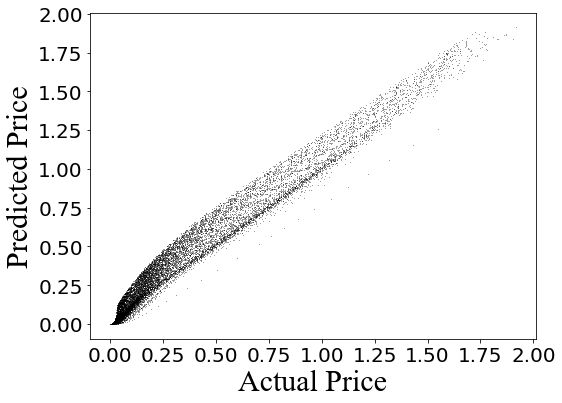

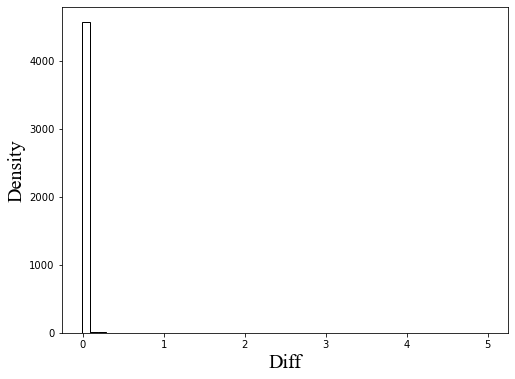

In [42]:
# Compare real values of the test set vs Black and scholes and The Neural network
CheckAccuracy(y_test, y_BS, label='ANN_eval_BS')

Mean Squared Error:       0.011371609293619241
Root Mean Squared Error:  0.1066377479770613
Mean Absolute Error:      0.04025380334209525
Mean Percent Error:       0.2885767574246851


{'mse': 0.011371609293619241,
 'rmse': 0.1066377479770613,
 'mae': 0.04025380334209525,
 'mpe': 0.2885767574246851}

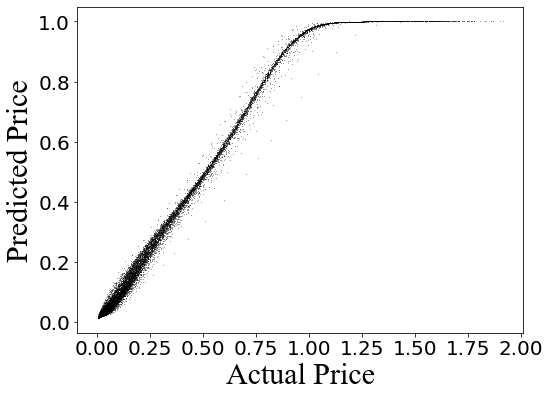

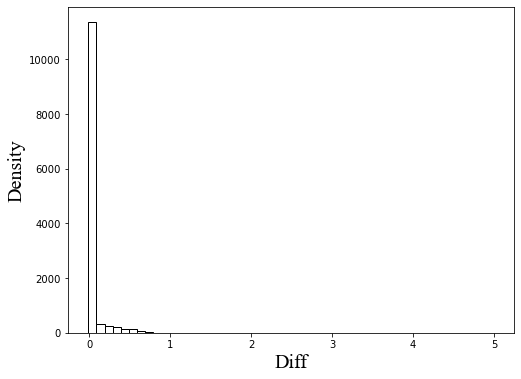

In [43]:
CheckAccuracy(y_test, y_hat[:,0], label='ANN_eval_NN')

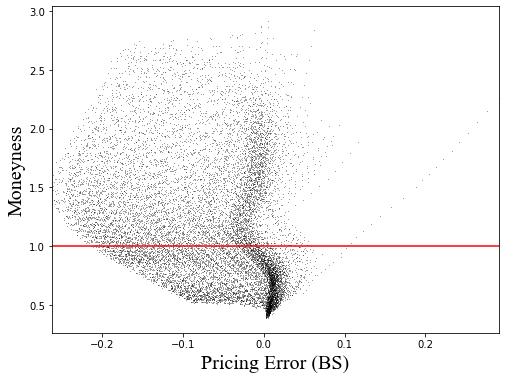

In [45]:
#plot moneyness
matplotlib.rcParams['agg.path.chunksize'] = 100000
plt.figure(figsize=(8,6))
pricing_error_BS = (y_test - y_BS)
plt.scatter(pricing_error_BS, y_moneyness, color='black',linewidth=0.3,alpha=0.4, s=0.5)
plt.plot([np.min(pricing_error_BS), np.max(pricing_error_BS)], [1, 1], 'r-')
plt.xlabel('Pricing Error (BS)',fontsize=20,fontname='Times New Roman')
plt.ylabel('Moneyness',fontsize=20,fontname='Times New Roman')
plt.xlim(np.min(pricing_error_BS), np.max(pricing_error_BS))
plt.xticks(fontsize=10) 
plt.yticks(fontsize=10) 
#plt.show()
plt.savefig('ANN_eval_BS_Moneyness_vs_Pricing_error.png', bbox_inches='tight')

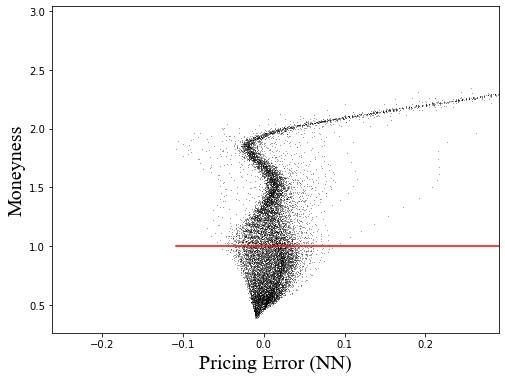

In [46]:
matplotlib.rcParams['agg.path.chunksize'] = 100000
plt.figure(figsize=(8,6))
pricing_error_NN = (y_test - y_hat[:,0])
plt.scatter(pricing_error_NN, y_moneyness, color='black',linewidth=0.3,alpha=0.4, s=0.5)
plt.plot([np.min(pricing_error_NN), np.max(pricing_error_NN)], [1, 1], 'r-')
plt.xlabel('Pricing Error (NN)',fontsize=20,fontname='Times New Roman')
plt.ylabel('Moneyness',fontsize=20,fontname='Times New Roman')
plt.xlim(np.min(pricing_error_BS), np.max(pricing_error_BS))
plt.xticks(fontsize=10) 
plt.yticks(fontsize=10) 
#plt.show()
plt.savefig('ANN_eval_NN_Moneyness_vs_Pricing_error.png', bbox_inches='tight')

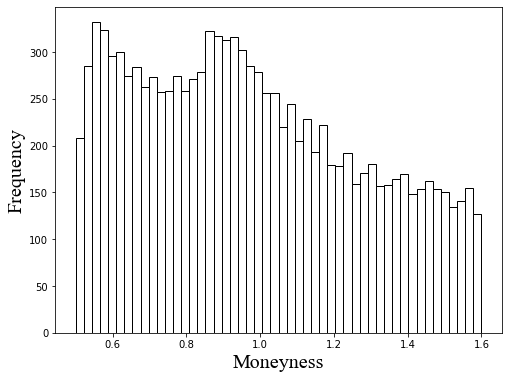

In [47]:
#plot moneyness
plt.figure(figsize=(8,6))
plt.hist(y_moneyness, range=[0.5, 1.6], bins=50,edgecolor='black',color='white')
plt.xlabel('Moneyness',fontsize=20,fontname='Times New Roman')
plt.ylabel('Frequency',fontsize=20,fontname='Times New Roman')
plt.xticks(fontsize=10) 
plt.yticks(fontsize=10) 
#plt.show()
plt.savefig('ANN_eval_moneyness_density.png', bbox_inches='tight')

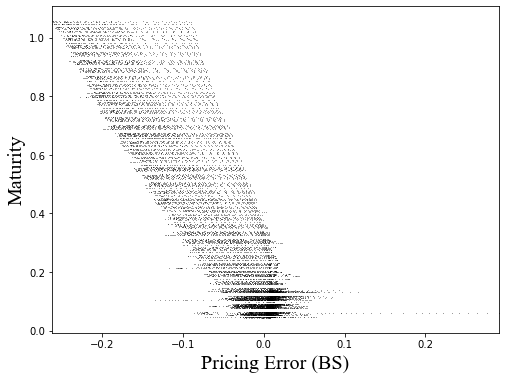

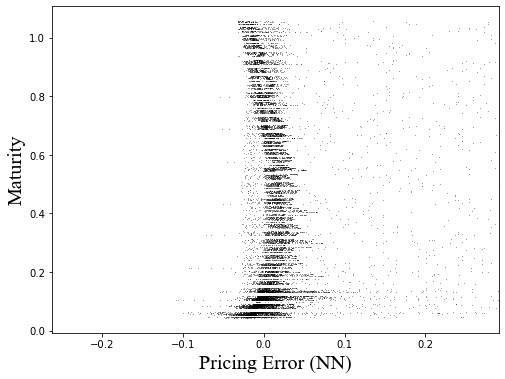

In [48]:
#plot maturity
matplotlib.rcParams['agg.path.chunksize'] = 100000
plt.figure(figsize=(8,6))
pricing_error_BS = (y_test - y_BS)
plt.scatter(pricing_error_BS, y_maturity, color='black',linewidth=0.3,alpha=0.4, s=0.5)
plt.xlabel('Pricing Error (BS)',fontsize=20,fontname='Times New Roman')
plt.ylabel('Maturity',fontsize=20,fontname='Times New Roman')
plt.xlim(np.min(pricing_error_BS), np.max(pricing_error_BS))
plt.xticks(fontsize=10) 
plt.yticks(fontsize=10) 
#plt.show()
plt.savefig('ANN_eval_BS_Maturity_vs_Pricing_error.png', bbox_inches='tight')

matplotlib.rcParams['agg.path.chunksize'] = 100000
plt.figure(figsize=(8,6))
pricing_error_NN = (y_test - y_hat[:,0])
plt.scatter(pricing_error_NN, y_maturity, color='black',linewidth=0.3,alpha=0.4, s=0.5)
plt.xlabel('Pricing Error (NN)',fontsize=20,fontname='Times New Roman')
plt.ylabel('Maturity',fontsize=20,fontname='Times New Roman')
plt.xlim(np.min(pricing_error_BS), np.max(pricing_error_BS))
plt.xticks(fontsize=10) 
plt.yticks(fontsize=10) 
#plt.show()
plt.savefig('ANN_eval_NN_Maturity_vs_Pricing_error.png', bbox_inches='tight')

In [49]:
# Summary Tables

from tabulate import tabulate

# ---------------------- All samples --------------------------

data = pricing_data
call = X 

# confidence intervals
alpha = 0.95
p1 = ((1.0-alpha)/2.0) * 100
p2 = (alpha+((1.0-alpha)/2.0)) * 100
resolution = 5

A = round(np.mean(data['mse_NN']), resolution)
B = round(np.mean(data['rmse_NN']), resolution)
C = round(np.mean(data['mae_NN']), resolution)
D = len(call)
E = '(' + str(round(max(0.0, np.percentile(data['mse_NN'], p1)), resolution)) + ',' +str(round(min(1.0, np.percentile(data['mse_NN'], p2)), resolution)) + ')'
F = '(' + str(round(max(0.0, np.percentile(data['rmse_NN'], p1)), resolution)) + ',' +str(round(min(1.0, np.percentile(data['rmse_NN'], p2)), resolution)) + ')'
G = '(' + str(round(max(0.0, np.percentile(data['mae_NN'], p1)), resolution)) + ',' +str(round(min(1.0, np.percentile(data['mae_NN'], p2)), resolution)) + ')'
H = round(np.mean(data['mse_BS']), resolution)
I = round(np.mean(data['rmse_BS']),resolution)
J = round(np.mean(data['mae_BS']), resolution)
K = '(' + str(round(max(0.0, np.percentile(data['mse_BS'], p1)), resolution)) + ',' +str(round(min(1.0, np.percentile(data['mse_BS'], p2)), resolution)) + ')'
L = '(' + str(round(max(0.0, np.percentile(data['rmse_BS'], p1)), resolution)) + ',' +str(round(min(1.0, np.percentile(data['rmse_BS'], p2)), resolution)) + ')'
M = '(' + str(round(max(0.0, np.percentile(data['mae_BS'], p1)), resolution)) + ',' +str(round(min(1.0, np.percentile(data['mae_BS'], p2)), resolution)) + ')'
N = 0
rows = [['Model'         , 'No. Observations', 'MSE', 'RMSE', 'MAE'],
        ['Neural network',       ''          ,     A,      B,     C],
        ['CI'            ,        D          ,     E,      F,     G],
        ['Black-Scholes' ,       ''          ,     H,      I,     J],
        ['CI'            ,       ''          ,     K,      L,     M]]

print('---------------------- All samples ---------------------------')
print('Tabulate Table:')
print(tabulate(rows, headers='firstrow'))

print('\nTabulate Latex:')
print(tabulate(rows, headers='firstrow', tablefmt='latex'))


---------------------- All samples ---------------------------
Tabulate Table:
Model           No. Observations    MSE                RMSE               MAE
--------------  ------------------  -----------------  -----------------  -----------------
Neural network                      0.01137            0.10664            0.04025
CI              76818               (0.01137,0.01137)  (0.10664,0.10664)  (0.04025,0.04025)
Black-Scholes                       0.01034            0.10168            0.07499
CI                                  (0.01034,0.01034)  (0.10168,0.10168)  (0.07499,0.07499)

Tabulate Latex:
\begin{tabular}{lllll}
\hline
 Model          & No. Observations   & MSE               & RMSE              & MAE               \\
\hline
 Neural network &                    & 0.01137           & 0.10664           & 0.04025           \\
 CI             & 76818              & (0.01137,0.01137) & (0.10664,0.10664) & (0.04025,0.04025) \\
 Black-Scholes  &                    & 0.01034   

# ANN - Delta Hedging 

In [50]:
# COMPUTE DERIVATIVE FOR ANN

def getBondValueANN(option_data):
    tau = 1 # tau is defined to be one day in the paper
    is_first = True
    V_B_ANN = list()
    V_B_previous = 0
    for index, row in option_data.iterrows():
    
        if is_first is True:
            V_B_it = -(row['V_S_ANN']+row['V_C_ANN'])
            V_B_ANN.append(V_B_it)
            V_B_previous = V_B_it
            is_first =  False
            continue
            
        term_A_1 = np.exp(row['ir']*tau)
        term_A_2 = V_B_previous
        term_A = term_A_1 * term_A_2
        term_B = row['S/X']*(row['delta_ANN']-row['delta_ANN_lag'])
        V_B_it = term_A - term_B
        V_B_ANN.append(V_B_it)
        V_B_previous = V_B_it
        
    return np.array(V_B_ANN)

def getBondValueBS(option_data):
    tau = 1 # tau is defined to be one day in the paper
    is_first = True
    V_B_BS = list()
    V_B_previous = 0
    for index, row in option_data.iterrows():
    
        if is_first is True:
            V_B_it = -(row['V_S_BS']+row['V_C_BS'])
            V_B_BS.append(V_B_it)
            V_B_previous = V_B_it
            is_first =  False
            continue
        
        term_A = np.exp(row['ir']*tau)*V_B_previous
        term_B = row['S/X']*(row['delta_BS']-row['delta_BS_lag'])
        V_B_it = term_A - term_B
        V_B_BS.append(V_B_it)
        V_B_previous = V_B_it
        
    return np.array(V_B_BS)

def getDer(row, sess, grad_func, model):
    
    x  = np.asarray([(0, 0)])

    x[0,0] = row['S/X']
    x[0,1] = row['T-t']

    gradients = sess.run(grad_func, feed_dict={model.input: x.reshape((1, x.size))})
    return np.array(gradients[0][0,:])[0]


def BS_d1(S, r, tau, sigma):
    """Auxiliary function for BS model"""
    d1 = (np.log(S)+(r+0.5*sigma**2)*tau)/(sigma*np.sqrt(tau))
    return(d1)      

def getDerivativeFromSampleBS(row):    
    d1 = BS_d1(row['S/X'], row['ir'] , row['T-t'], annual_volatility)
    delta_BS = scipy.stats.norm.cdf(d1)
    return delta_BS


In [63]:
#####################################################################################################

import tensorflow as tf

# Load the dataset
data = df2

# Add a column with the index for each sample. This is used for selecting the test and training test
data['index'] = range(1, len(data) + 1)

num_of_sample = int(0.8 * len(data))
num_of_epochs = 1
num_of_bootstraping_iter = 1 
# if increase the no of iteration, the maximum recursion depth exceeded 
# need to increasing the recursion limit in Python
# due to the limitation in the computational resource, we use 1 here for illustration purposes 
test_loss_min = 1

 
# Build the model
model = build(X.iloc[:,0:2])
base_filename = 'ANN'
model.load_weights(base_filename + '_weights.h5')
# grad_func = tf.GradientTape(model.output[:, 0], model.input)
# grad_func = tf.gradients(model.output[:, 0], model.input)


performance_data = pd.DataFrame(columns=['num_of_options', 'epsilon_BS', 'nu_BS', 'epsilon_ANN', 'nu_ANN', 
                                'tracking_error_ANN', 'tracking_error_BS'])
    
performance_data_it = pd.DataFrame(columns=['optionid', 'epsilon_BS', 'nu_BS', 'epsilon_ANN', 'nu_ANN', 
                                'moneyness', 'interest', 'maturity', 'tracking_error_ANN', 'tracking_error_BS'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 4)                 12        
                                                                 
 dense_9 (Dense)             (None, 1)                 5         
                                                                 
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


In [64]:
# Diable the warnings
import warnings
warnings.filterwarnings("ignore")

In [65]:
from sklearn.utils import resample

# import tensorflow.compat.v1 as tf
import tensorflow as tf

print(tf.__version__)

2.10.0


In [66]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

a=tf.Variable(0, name='input')
b=tf.constant(1)

mid_val =tf.add(a,b)
update_value =tf.compat.v1.assign(a,mid_val)
tg=tf.compat.v1.initialize_all_variables()   #add tf.compat.v1 to initialize_all_variables() function


with tf.compat.v1.Session() as sess:
  sess.run(tg)
  print(sess.run(a))

  for i in range(3):
    sess.run(update_value)
    print(sess.run(a))

0
1
2
3


In [67]:
# grad_func = tf.GradientTape(model.output[:, 0], model.input)
grad_func = tf.gradients(model.output[:, 0], model.input)

In [68]:
for bootstraping_iter in range(num_of_bootstraping_iter):
       
    boot_indexes = resample(data['index'], replace=True, n_samples=num_of_sample, random_state=bootstraping_iter)
    oob_indexes  = [x for x in data['index'] if x not in boot_indexes]
    
    boot = resample(data, replace=True, n_samples=num_of_sample, random_state=bootstraping_iter)
    test_hedge =  data.loc[data['index'].isin(oob_indexes)]
    
    X_test = test_hedge[['S/X','T-t']]
    Y_test = test_hedge['Mkt_Opt_Price']/test_hedge['strike_price']
    
    
    # Group by option id and conunt how many different options there are
    numb_options = test_hedge.groupby(['optionid'])['date'].count()
    #change name from date to count
    numb_options = pd.DataFrame(numb_options)
    numb_options = numb_options.rename(columns = {"date": "count"})
    #merge numb_options with test_hedge
    hedge_data = test_hedge.merge(numb_options,left_on='optionid', right_on='optionid')
    
    #keep only the options with more than 10 observationshedge_data = hedge_data[hedge_data['count']>10]
    hedge_data = hedge_data[hedge_data['count']>10]
    count_options = hedge_data.groupby(['optionid'])['date'].count()
    
    # Group the data by Option ID
    hedge_data_grouped = list(hedge_data.groupby(['optionid']))
    
    for option in hedge_data_grouped: 

        sess = tf.compat.v1.InteractiveSession()
#         sess.run(tf.compat.v1.global_variables_initializer())
#         sess = tf.compat.v1.Session()
#         sess = tf.compat.v1.InteractiveSession()
        sess.run(tf.compat.v1.initialize_all_variables())
#         sess.run(tf.compat.v1.global_variables_initializer())
#         sess.run(tf.global_variables_initializer())
    
    
        # Get the dataframe containing the option data and sort it by date
        option_data = option[1]
        option_data = option_data.sort_values(by=['date'])
        
      
        # ---------------------------- ANN -----------------------------------------
        option_data_it = option_data[['S/X','T-t']]   
        
        # ---------------------------- ANN -----------------------------------------       
        option_data['delta_ANN'] = np.asarray([ getDer(row, sess=sess, grad_func=grad_func, model=model) for index, row in option_data_it.iterrows()])
        option_data['delta_ANN_lag'] = option_data['delta_ANN'].shift(1)
           
        option_data['V_S_ANN'] = option_data['S/X'] * option_data['delta_ANN']
        option_data['V_C_ANN'] = -option_data['BS_Opt_Price']
        option_data['V_B_ANN'] = getBondValueANN(option_data)   
        
        option_data['V_T_ANN'] = option_data['V_S_ANN'] + option_data['V_C_ANN'] + option_data['V_B_ANN']
            
           
        # ---------------------------- BS -----------------------------------------
        option_data['delta_BS'] = np.asarray([ getDerivativeFromSampleBS(row) for index, row in option_data.iterrows()])
        option_data['delta_BS_lag'] = option_data['delta_BS'].shift(1)
        
        option_data['V_S_BS'] = option_data['S/X'] * option_data['delta_BS']
        option_data['V_C_BS'] = -option_data['BS_Opt_Price']
        option_data['V_B_BS'] = getBondValueBS(option_data)   
        
        option_data['V_T_BS'] = option_data['V_S_BS'] + option_data['V_C_BS'] + option_data['V_B_BS']
            
       
        # Get last row of the option_data dataframe
        last_sample = option_data.tail(1)
        
        epsilon_BS =  np.exp(-last_sample['ir']*last_sample['T-t']) * np.mean(np.abs(option_data['V_T_BS']))
        nu_BS = np.exp(-last_sample['ir']*last_sample['T-t']) * np.sqrt(np.mean(option_data['V_T_BS'])+np.var(option_data['V_T_BS']))
        epsilon_ANN = np.exp(-last_sample['ir']*last_sample['T-t']) * np.mean(np.abs(option_data['V_T_ANN']))
        nu_ANN = np.exp(-last_sample['ir']*last_sample['T-t']) * np.sqrt(np.mean(option_data['V_T_ANN'])+np.var(option_data['V_T_ANN']))
        
        performance_data_it = performance_data_it.append([{ 
                                                  'optionid': str(option[0]),
                                                  'epsilon_BS': np.asarray(epsilon_BS)[0],
                                                  'nu_BS': np.asarray(nu_BS)[0],
                                                  'epsilon_ANN': np.asarray(epsilon_ANN)[0],
                                                  'nu_ANN': np.asarray(nu_ANN)[0],
                                                  'moneyness': np.asarray(last_sample['S/X'])[0],
#                                                   'interest': np.asarray(last_sample['DTB3'])[0],
                                                  'interest': np.asarray(last_sample['ir'])[0],
                                                  'maturity': np.asarray(last_sample['T-t'])[0],
                                                  'tracking_error_ANN': np.asarray(last_sample['V_T_ANN'])[0],
                                                  'tracking_error_BS': np.asarray(last_sample['V_T_BS'])[0],
                                                  }], 
                                                 ignore_index=True)
        
    
    
    
    performance_data = performance_data.append([{ 'num_of_options': len(hedge_data_grouped),
                                                  'epsilon_BS': np.mean(performance_data_it['epsilon_BS']),
                                                  'nu_BS':np.mean(performance_data_it['nu_BS']),
                                                  'epsilon_ANN': np.mean(performance_data_it['epsilon_ANN']),
                                                  'nu_ANN': np.mean(performance_data_it['nu_ANN']),
                                                  'tracking_error_ANN': np.mean(performance_data_it['tracking_error_ANN']),
                                                  'tracking_error_BS': np.mean(performance_data_it['tracking_error_BS']),
                                                  }], 
                                                 ignore_index=True)
    

In [69]:
performance_data_it

,optionid,epsilon_BS,nu_BS,epsilon_ANN,nu_ANN,moneyness,interest,maturity,tracking_error_ANN,tracking_error_BS
0,135658612,1.913466,2.215980,2.121907,2.436044,2.409838,0.0008,0.047619,3.396385,3.046839
1,135658613,1.933276,2.235369,2.122023,2.434575,2.190762,0.0008,0.047619,3.401095,3.087078
2,135658614,1.950463,2.250202,2.122767,2.432018,2.008198,0.0008,0.047619,3.425190,3.136884
3,135658615,1.965070,2.260452,2.122913,2.426343,1.853722,0.0008,0.047619,3.471418,3.200418
4,135658616,1.978845,2.265734,2.123786,2.417649,1.721313,0.0008,0.047619,3.529931,3.279912
...,...,...,...,...,...,...,...,...,...,...
1873,144078745,0.344401,0.609774,0.347057,0.612104,0.518654,0.0005,0.047619,0.549909,0.547400
1874,144078746,0.259332,0.522714,0.260720,0.524031,0.486238,0.0005,0.047619,0.397466,0.397052
1875,144078747,0.194164,0.448553,0.194708,0.449086,0.457636,0.0005,0.047619,0.286774,0.287652
1876,144078748,0.130231,0.365364,0.130570,0.365788,0.445542,0.0005,0.059524,0.205430,0.206465


In [70]:
performance_data

,num_of_options,epsilon_BS,nu_BS,epsilon_ANN,nu_ANN,tracking_error_ANN,tracking_error_BS
0,1878,1.578401,1.570971,1.648389,1.623691,2.817824,2.714089


In [ ]:
# data = performance_data

# mean_TE_BS = np.mean(np.abs(data['tracking_error_BS']))
# mean_TE_ANN = np.mean(np.abs(data['tracking_error_ANN']))

# std_TE_BS = np.std(data['tracking_error_BS'])
# std_TE_ANN = np.std(data['tracking_error_ANN'])


# T_value = stats.ttest_ind(np.asarray(data['tracking_error_BS']), np.asarray(data['tracking_error_ANN']))


# plt.hist(data['tracking_error_BS'], bins=15, color='c', edgecolor='k', alpha=0.5)
# plt.hist(data['tracking_error_ANN'], bins=15, color='g', edgecolor='k', alpha=0.5)


In [71]:
## Summary table with the results
from tabulate import tabulate

data = performance_data_it
data['tracking_error_ANN']=np.abs(data['tracking_error_ANN'])
data['tracking_error_BS']=np.abs(data['tracking_error_BS'])


resolution = 5
data_ITM = data[data['moneyness'] > 1.05]
t_test_ITM = stats.ttest_ind_from_stats(np.mean(data_ITM['tracking_error_ANN']), 
                                        np.std(data_ITM['tracking_error_ANN']),
                                        len(data_ITM['tracking_error_ANN']), 
                                        np.mean(data_ITM['tracking_error_BS']),
                                        np.std(data_ITM['tracking_error_BS']),
                                        len(data_ITM['tracking_error_BS']))

print(t_test_ITM)
A = np.round(t_test_ITM[0], resolution)
B = np.round(t_test_ITM[1], resolution)
C = len(data_ITM)
D = np.round((len(data_ITM[(data_ITM['tracking_error_ANN'] < data_ITM['tracking_error_BS'])])/C) *100,2)

data_OTM = data[data['moneyness'] < 0.95]
t_test_OTM = stats.ttest_ind(data_OTM['tracking_error_ANN'], data_OTM['tracking_error_BS'])
print(t_test_OTM)
E = np.round(t_test_OTM[0], resolution)
F = np.round(t_test_OTM[1], resolution)
G = len(data_OTM)
H = np.round((len(data_OTM[(data_OTM['tracking_error_ANN'] < data_OTM['tracking_error_BS'])])/G) *100,2)

data_ATM = data[(data['moneyness'] <= 1.05 ) & (data['moneyness'] >= 0.95)]
t_test_ATM = stats.ttest_ind(data_ATM['tracking_error_ANN'], data_ATM['tracking_error_BS'])
print(t_test_ATM)
I = np.round(t_test_ATM[0], resolution)
J = np.round(t_test_ATM[1], resolution)
K = len(data_ATM)
L = np.round((len(data_ATM[(data_ATM['tracking_error_ANN'] < data_ATM['tracking_error_BS'])])/K) *100,2)
t_test = stats.ttest_ind(data['tracking_error_ANN'], data['tracking_error_BS'])

print(t_test)
M = np.round(t_test[0], resolution)
N = np.round(t_test[1], resolution)
O = len(data)
P = np.round((len(data[(data['tracking_error_ANN'] < data['tracking_error_BS'])])/O) *100,2)

rows = [['Sample'                    , 't-statistic', 'p-value', 'Observations', '% NN < BS'],
        ['ITM (moneyness > 1.05)',                 A,         B,              C,           D],
        ['OTM (moneyness < 0.95)',                 E,         F,              G,           H],
        ['ATM (0.95 <= moneyness <= 1.05)',        I,         J,              K,           L],
        ['All',                                    M,         N,              O,           P]]

print('---------------------- All samples ---------------------------')
print('Tabulate Table:')
print(tabulate(rows, headers='firstrow'))

print('\nTabulate Latex:')
print(tabulate(rows, headers='firstrow', tablefmt='latex'))

Ttest_indResult(statistic=1.5976244315969776, pvalue=0.11030836580459377)
Ttest_indResult(statistic=0.35119662246846867, pvalue=0.725482878907875)
Ttest_indResult(statistic=0.3068874776224395, pvalue=0.7591824542359364)
Ttest_indResult(statistic=1.3839361649215791, pvalue=0.16646027460217422)
---------------------- All samples ---------------------------
Tabulate Table:
Sample                             t-statistic    p-value    Observations    % NN < BS
-------------------------------  -------------  ---------  --------------  -----------
ITM (moneyness > 1.05)                 1.59762    0.11031             870         5.86
OTM (moneyness < 0.95)                 0.3512     0.72548             881         9.53
ATM (0.95 <= moneyness <= 1.05)        0.30689    0.75918             127         8.66
All                                    1.38394    0.16646            1878         7.77

Tabulate Latex:
\begin{tabular}{lrrrr}
\hline
 Sample                          &   t-statistic &   p-val

### RBF = 4 multi-quadtratic function, output sigmoid
### PPR = 4 projections

### Generate path


In [ ]:
# num_folds = 2
# seed = 7
# scoring = "neg_mean_squared_error"

# names = []

# kfold_results = []

# train_results = []
# test_results = []

# for name, model in models:
#     names.append(name)
    
#     # Let's run K-Fold analysis
    
#     kfold = KFold(n_splits = num_folds,
#                   random_state = seed,shuffle=True)
    
#     # Let's convert MSE to positive (HERE, the lower the better)
    
#     cv_results = -1 * cross_val_score(model, X_train, Y_train,
#                                       cv = kfold,
#                                       scoring = scoring)
    
#     kfold_results.append(cv_results) # REMEMBER TO ADD THIS
    
#     # Entire training period
    
#     res = model.fit(X_train, Y_train)
#     train_result = mean_squared_error(res.predict(X_train), Y_train)
#     train_results.append(train_result)
    
#     # Results for test
    
#     test_result = mean_squared_error(res.predict(X_test), Y_test)
#     test_results.append(test_result)
    
#     message = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
#     print(message)

In [ ]:
# fig = plt.figure(figsize = (16, 8)
#                  )

# ind = np.arange(len(names)
#                ) 
# width = 0.35

# fig.suptitle("Comparing the Performance of Various Algorithms on the Training and Testing Datasets")
# ax = fig.add_subplot(111)

# plt.bar(ind - width/2, 
#         train_results, 
#         width = width,
#         label = "Errors in Training Set")

# plt.bar(ind + width/2, 
#         test_results, 
#         width = width,
#         label = "Errors in Testing Set")

# plt.legend()

# ax.set_xticks(ind)
# ax.set_xticklabels(names)

# plt.ylabel("Mean Squared Error")

# plt.show()

In [ ]:
# def geo_paths(S, T, r,  sigma, steps, paths):
#     """
#     Inputs
#     #S = Current stock Price
#     #K = Strike Price
#     #T = Time to maturity 1 year = 1, 1 months = 1/12
#     #r = risk free interest rate
#     #q = dividend yield
#     # sigma = volatility 

#     Output
#     # [steps,N] Matrix of asset paths 
#     """

#     deltaT = T/steps
#     t = np.linspace(0, T, steps+1)
#     X = np.c_[np.zeros((paths, 1)),
#               np.random.randn(paths, steps)]
#     T = t
#     W_T = np.cumsum(np.sqrt(deltaT) * X, axis=1)

#     blackscholespath = S*np.exp((r-sigma**2/2)*T + sigma*W_T[0])
#     last_value = float(blackscholespath[-1])

#     return blackscholespath,last_value



In [ ]:

# K = 10 # strike - not applicable for now
# q = 0 # annual dividend rate - not applicable for now
# S = 10 #stock price S_{0}
# T = 1 # time to maturity converted to daily
# r = 0.05 # risk free risk in annual % 
# sigma = 0.4 # annual volatility in %
# steps = 200 # time steps this is just to calibrate a longer brownian motion walk 
# paths = 1 # number of price paths to produce

# blackscholespath, last_value = geo_paths(S,T,r, sigma,steps,paths)
# # paths is an array which show the values as the number of steps, i.e. if N = 2 , means 2 price path, and steps the price path

# plt.plot(blackscholespath)
# plt.xlabel("Time Increments")
# plt.ylabel("Stock Price")
# plt.title("Geometric Brownian Motion")

In [ ]:
# price_paths = 2

# cols = []

# for path in range(1, price_paths +1):
    
#     col = "path_{}".format(path)
#     df[col] = df['forward_price'].apply(lambda x:geo_paths(x,1/252,annual_return,0,annual_volatility,168,1)[1])
#     cols.append(col)